# Imports

In [1]:
### Data Manipulation
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Cell output display -- all
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

### Ignore exceptions
import expectexception

### Modeling libraries
import xgboost as xgb
import category_encoders as ce
from sklearn.model_selection import TimeSeriesSplit
from hyperopt import hp, tpe, fmin, Trials

# Data

In [2]:
train_tr = pd.read_csv('./data/train_transaction.csv')
train_id = pd.read_csv('./data/train_identity.csv')
test_tr = pd.read_csv('./data/test_transaction.csv')
test_id = pd.read_csv('./data/test_identity.csv')

In [3]:
tr_raw = pd.merge(train_tr, train_id, how='left')
test_raw = pd.merge(test_tr, test_id, how='left')

target = tr_raw['isFraud']
train = tr_raw.copy().drop('isFraud', axis=1)
test = test_raw.copy()
data = pd.concat([train, test])

In [4]:
def paste0(string, start, end):
    return list(map(lambda x: ''.join(x), zip([string]*(end - start + 1), map(str, range(start, end + 1)))))

cards = paste0('card', 1, 6)
Ms = paste0('M', 1, 9)
ids = paste0('id_', 12, 38)

cat_tr = ['ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + cards + Ms
cat_id = ['DeviceType', 'DeviceInfo'] + ids

# Feature Engineering

In [5]:
train['weekday'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
test['weekday'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)
train['hour'] = np.floor(train['TransactionDT'] / 3600) % 24
test['hour'] = np.floor(test['TransactionDT'] / 3600) % 24

def domains_process(row): 
    if pd.isnull(row['P_emaildomain']) and pd.isnull(row['R_emaildomain']):
        return "Both_Missing"
    elif pd.isnull(row['P_emaildomain']):
        return "P_Missing"
    elif pd.isnull(row['R_emaildomain']):
        return "R_Missing"
    elif row['P_emaildomain'] == row['R_emaildomain']:
        return("Same_Emails")
    else:
        return("Different_Emails")

train['email_status'] = train.apply(domains_process, axis=1)
test['email_status'] = test.apply(domains_process, axis=1)

# Encodings

In [6]:
from pandas.api.types import is_string_dtype

### extract string columns for encoding
def str_cols(in_df):
    df = in_df.copy()
    return [col for col in df.columns if is_string_dtype(df[col])]

### classify label-encoded vs target-encoded columns via brute rule
def encodings(in_df, cols):
    df = in_df.copy()
    labels = [col for col in cols if df[col].nunique() == 2]
    one_hot = [col for col in cols if df[col].nunique() > 2 and df[col].nunique() < 10]
    targets = [col for col in cols if df[col].nunique() > 10]
    return one_hot, labels, targets

In [7]:
string_columns = str_cols(data)
one_hot, labels, targets = encodings(data, string_columns)

In [8]:
### Label encoding 
data_labels = data[labels]
ce_ord = ce.OrdinalEncoder(cols=labels, impute_missing=False)
data[labels] = ce_ord.fit_transform(data_labels)

In [9]:
### Leave-one-out target encoding
training_rows = train.shape[0]
train_split = data.iloc[range(training_rows), :]
test_split = data.iloc[training_rows::, :]

training_targets = train_split[targets]
testing_targets = test_split[targets]

ce_LOO = ce.LeaveOneOutEncoder(cols=targets, impute_missing=False, handle_unknown='value', sigma=0.05)
train_split[targets] = ce_LOO.fit_transform(training_targets, target)
test_split[targets] = ce_LOO.transform(testing_targets)

/Users/jng/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [10]:
from itertools import compress

### 'handle_unknown' arg in LOO encoder does not work
### manual handling of mismatched test_split values turned into NaNs

### initialise reference dataframe
temp = data.iloc[training_rows::, :]

### create mask to identify unequal NaN columns
mismatched = test_split[targets].isnull().sum() != temp[targets].isnull().sum()

### impute mismatched row values
for col in mismatched[mismatched == 1].index:
    mismatched_row = test_split[col].isnull() != temp[col].isnull()
    
    ### identify mismatched indices
    row_ids = list(compress(range(len(mismatched_row.values)), mismatched_row))
    
    ### compute mean of the mean of the column
    mean_mean = train_split[col].sum()/train_split[col].count()
#     impute = [mean_mean] * len(row_ids)
    
    ### impute mean of the mean into NaN ids
    test_split[col][row_ids] = mean_mean

    ### check null length against reference column
    if (test_split[col].isnull().sum() != temp[col].isnull().sum()):
        print('{} still not equal!'.format(col))

/Users/jng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jng/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_labels(key, value)
/Users/jng/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, s

In [11]:
### One Hot encoding
data2 = pd.concat([train_split, test_split])
data2 = pd.get_dummies(data2, dummy_na=True, columns=one_hot)

train2 = data2.iloc[range(training_rows), :]
test2 = data2.iloc[training_rows::, :]

# Sampled GridSearch

In [47]:
X_train = train2.sample(frac = .05)
X_test = test2.sample(frac = .05)
response = target[X_train.index]

In [45]:
X_train = train2
X_test = test2
target = tr_raw['isFraud']

In [49]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

#Define hyperparameter tune grid
param_grid = {
        'min_child_weight': [1],
        'gamma':[2, 3, 4, 5, 6, 7],
        'subsample': [0.9],
        'learning_rate': [.05],
        'max_depth': [9],
        'alpha': [0.005],
        'lambda': [0.1]
        }

xgb = XGBClassifier(
        n_estimators=600,
        colsample_bytree=0.9,
        tree_method='hist') 
#         reg_alpha=0.15,
#         reg_lambda=0.85)

cv = TimeSeriesSplit(n_splits=5)

CV_object = GridSearchCV(estimator = xgb,
                         param_grid = param_grid,
                         n_jobs=4,
                         scoring = 'roc_auc',
                         cv = cv,
                         iid=False,
                         verbose=1)

target = response
CV_object.fit(X_train, target)

print("Best Parameters:")
print(CV_object.best_params_)
print("Best Score:")
print(CV_object.best_score_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 10.2min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.9, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=600, n_jobs=1,
                                     nthread=None, objective='b...
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='hist',
                                     verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'alpha': [0.005], 'gamma': [2, 3, 4, 5, 

Best Parameters:
{'alpha': 0.005, 'gamma': 4, 'lambda': 0.1, 'learning_rate': 0.05, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.9}
Best Score:
0.9896654937269723


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=4,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.005, reg_lambda=0.1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, tree_method='hist', verbosity=1)

predictions exported to csv file


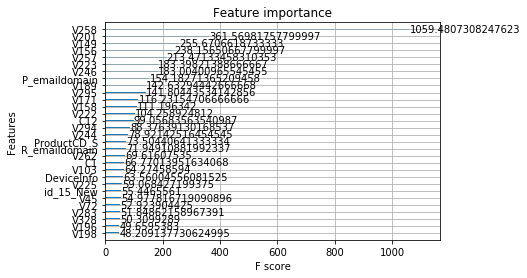

In [46]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb = XGBClassifier(
        n_estimators=500,
        gamma = 4,
        max_depth=9,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        tree_method='hist', 
        reg_alpha=0.005,
        reg_lambda=0.1,
        min_child_weight = 1
    )

xgb.fit(X_train, target)
val = xgb.predict_proba(X_test)[:,1]

#create data frame of results
test_result = pd.DataFrame({'TransactionID': X_test['TransactionID'], 'isFraud' : val})

#Save to csv file in submission format
test_result.to_csv('xgb_naive.csv',index=False)

print("predictions exported to csv file")


import matplotlib.pylab as plt
from matplotlib import pyplot
from xgboost import plot_importance
plot_importance(xgb, max_num_features=30,importance_type='gain') # top 10 most important features
plt.show()
